In [233]:
import pandas as pd
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


In [234]:
df = pd.read_excel("../data/processed/preprocessed_final.xlsx")

In [235]:
# Select categorical columns for one-hot encoding
categorical_columns = ['institution', 'program', 'degree_type', 'decision']

In [236]:
# Initialize label encoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder for future inverse mapping if needed


In [237]:

le = label_encoders[categorical_columns[3]]
print("Label mapping for 'decision':")
for idx, label in enumerate(le.classes_):
    print(f"  {label} => {idx}")


Label mapping for 'decision':
  Accepted => 0
  Interview => 1
  Other => 2
  Rejected => 3
  Wait listed => 4


In [238]:
df.head(5)

,Unnamed: 0,id,acceptance_rate,institution,program,degree_type,decision,undergrad_gpa,gre_quantitative_reasoning,gre_verbal_reasoning,analytical_writing,notes,gre_total
0,0,879550,31.0,1070,2848,6,3,3.931486,132,146,2.0,NaN,278
1,1,879549,32.0,861,687,6,3,3.990000,136,142,5.6,Rejected at midnight PDT after interview. my C...,278
2,2,879548,45.0,520,7281,6,3,3.811025,138,152,4.4,NaN,290
3,3,879547,44.0,906,6375,6,0,3.560000,133,138,4.7,"Acceptance letter from the department, officia...",271
4,4,879546,40.0,155,3669,6,3,3.897579,140,150,6.0,email from POI,290


### Create new features


In [239]:
df['gpa_percentile'] = df['undergrad_gpa'] / 4.0  # assuming 4.0 scale
df['gre_avg'] = (df['gre_quantitative_reasoning'] + df['gre_verbal_reasoning']) / 2
df['gpa_x_acceptancerate'] = df['undergrad_gpa'] * df['acceptance_rate']

### Scale numeric features

In [240]:
numeric_features = ['acceptance_rate', 'undergrad_gpa', 'gre_quantitative_reasoning',
                    'gre_verbal_reasoning', 'analytical_writing', 'gre_total', 'gpa_percentile',
                    'gre_avg', 'gpa_x_acceptancerate']

In [241]:

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [242]:
# # Step 1: Map unique institutions to their known (non-null) acceptance rates
# institution_acceptance_map = (
#     df[df['acceptance_rate'].notnull()]
#     .groupby('institution')['acceptance_rate']
#     .first()
#     .to_dict()
# )

# # Step 2: Find rows where acceptance_rate is null
# null_acceptance_rows = df[df['acceptance_rate'].isnull()]

# # Step 3 & 4: Fill missing acceptance rates based on institution name
# df.loc[df['acceptance_rate'].isnull(), 'acceptance_rate'] = df.loc[
#     df['acceptance_rate'].isnull(), 'institution'
# ].map(institution_acceptance_map)

# # Optional: Save the updated DataFrame to a new Excel file
# df.to_excel("../data/processed/loaded_data.xlsx")

# df = pd.read_excel("../data/processed/loaded_data.xlsx")

# df = df.dropna(subset=['institution', 'program', 'degree_type', 'decision'])

# df.acceptance_rate.isna()
# 7734

In [243]:
# Drop non-numeric or irrelevant columns
df = df.drop(columns=['notes', 'Unnamed: 0'])

In [244]:
grouped_map = {
    0: 0,  # Accepted
    1: 2,  # Interview → Other
    2: 2,  # Other → Other
    3: 1,  # Rejected
    4: 2   # Wait listed → Other
}
df['decision_grouped'] = df['decision'].map(grouped_map)

In [245]:
df.to_excel("../data/processed/exploratory_analysis.xlsx")

In [246]:
feature_cols = [
    'acceptance_rate',
    'undergrad_gpa',
    'gre_quantitative_reasoning',
    'gre_verbal_reasoning',
    'analytical_writing',
    'gre_total',
    'gpa_percentile',
    'gre_avg',
    'gpa_x_acceptancerate',
    'program',          
    'degree_type',     
    'institution'        
]


In [247]:
# Separate features and target
X = df.drop(columns=['decision'])  # Features
y = df['decision']                 # Target (label-encoded decision)

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 1.2965
R² Score: 0.4620


___________________________________________________________________________________

In [248]:

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_rf:.4f}")


Random Forest - Mean Squared Error: 0.3516
Random Forest - R² Score: 0.8541


________________________________________________________________________________

In [249]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [250]:
y_pred_xgb = xgb_model.predict(X_test)


In [251]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [252]:
print(f"XGBoost - Mean Squared Error: {mse_xgb:.4f}")
print(f"XGBoost - R² Score: {r2_xgb:.4f}")

XGBoost - Mean Squared Error: 0.3628
XGBoost - R² Score: 0.8494


________________________________________________________________________________

In [253]:
# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [254]:
# Initialize base model
rf = RandomForestRegressor(random_state=42)


In [255]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)


In [256]:
# Run grid search
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [ ]:
# Best model from search
best_rf = grid_search.best_estimator_

In [ ]:
y_pred_best = best_rf.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Random Forest - MSE: {mse_best:.4f}, R²: {r2_best:.4f}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest - MSE: 1.9538, R²: 0.1892


In [ ]:

# Define classifier and parameter grid
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [ ]:
# Grid search
grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_clf.fit(X_train, y_train)
best_clf = grid_search_clf.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Evaluate
y_pred = best_clf.predict(X_test)
print("Best Parameters:", grid_search_clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.5522484472049689
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.65      0.61      7440
           1       0.62      0.45      0.52      2687
           2       0.45      0.63      0.52       316
           3       0.55      0.63      0.58      7095
           4       0.37      0.18      0.24      2587

    accuracy                           0.55     20125
   macro avg       0.51      0.51      0.50     20125
weighted avg       0.54      0.55      0.54     20125

Confusion Matrix:
 [[4807  290  115 1911  317]
 [ 675 1214    7  682  109]
 [  59    9  200   45    3]
 [1887  352   87 4436  333]
 [ 930  101   37 1062  457]]


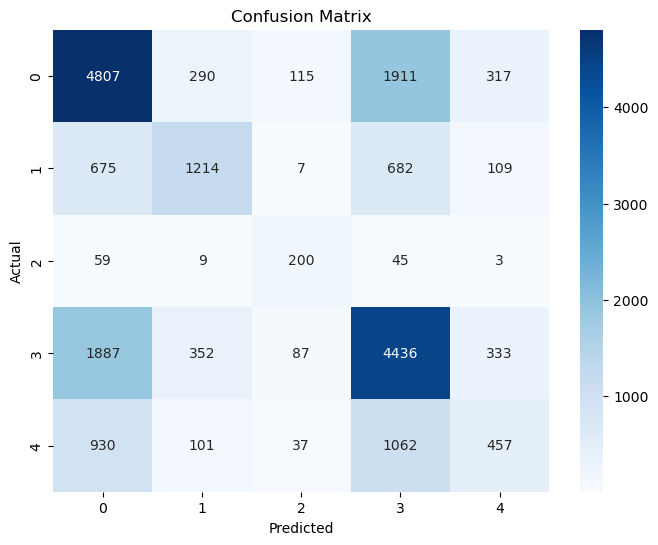

In [ ]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Flow

- Make sure data is distributed evenly
- encode target variable
- use label encoding for "string" data columns
- run feature engineering
    -  to reduce number of features
- check correlation between columns
- run model training
- run eval on test dataset
- create api endpoint for the model

In [ ]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.59      0.64      0.61      7440
           1       0.56      0.53      0.54      2687
           2       0.39      0.71      0.50       316
           3       0.56      0.59      0.57      7095
           4       0.37      0.20      0.26      2587

    accuracy                           0.55     20125
   macro avg       0.49      0.53      0.50     20125
weighted avg       0.54      0.55      0.54     20125



In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_sm, y_train_sm)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict and evaluate
y_pred = xgb_clf.predict(X_test)

In [ ]:
# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5506583850931677
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61      7440
           1       0.56      0.53      0.54      2687
           2       0.39      0.71      0.50       316
           3       0.56      0.59      0.57      7095
           4       0.37      0.20      0.26      2587

    accuracy                           0.55     20125
   macro avg       0.49      0.53      0.50     20125
weighted avg       0.54      0.55      0.54     20125

Confusion Matrix:
 [[4726  422  170 1745  377]
 [ 588 1422   15  552  110]
 [  42    9  223   35    7]
 [1810  564  132 4194  395]
 [ 901  120   37 1012  517]]
